# Working with images

Let's continue with image basics: in addition to creating our own images, we can also load existing image files and manipulate them with our code.

In [1]:
from PIL import Image

In [2]:
# module for dealing with the web
import requests

# online location of a photo from the Mount Allison University Archives
url = 'http://archives.ad.mta.ca/archives/ImageWatermarker.ashx?img=2007_07_1433.jpg'

# download the file
print('downloading')
response = requests.get(url, stream=True)
if not response.ok:
    response.raise_for_status()

# open as image, convert to greyscale
print('converting')
photo = Image.open(response.raw).convert('L')

# reduce size
print('resizing')
photo = photo.resize((photo.width//5, photo.height//5))

# save local copy of resized image
print('saving')
photo.save('1891-sm-grey.jpg')

print('done!')

downloading
converting
resizing
saving
done!


In [3]:
# The Mount Allison Latin class of 1891 --- “Worst class ever known”
photo = Image.open('1891-sm-grey.jpg')

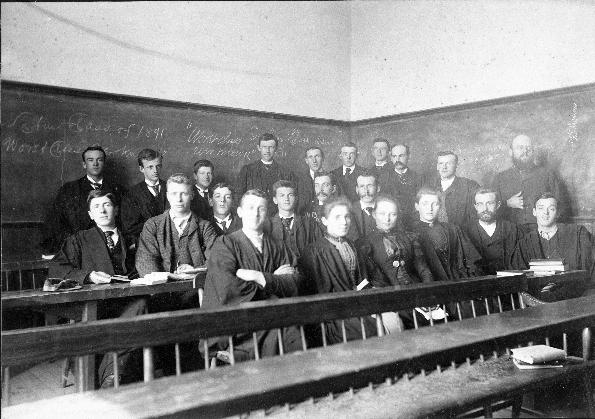

In [4]:
photo

Now that we've loaded this file into an Image object, we can treat it just like our home-made images, getting and setting arbitrary pixels.

First, let's see what the image dimensions are.

In [5]:
print(photo.size)

(595, 419)


Let's compare the grey values of the pixels at the lower-right and top-right corners.
 - lower-right is dark, should be a low number
 - upper-right is light, should be a high number

In [6]:
print('lower right:', photo.getpixel((photo.width-1, photo.height-1)))
print('upper right:', photo.getpixel((photo.width-1, 0)))

lower right: 29
upper right: 219


### Modifying pixels

Let's redo the grid of vertical and horizontal lines from Tuesday's class, drawing the lines overtop of our photo. 

We don't want to permanently mess up our image, so we'll use the `copy` method to create a new copy first, then do our experiment on that.

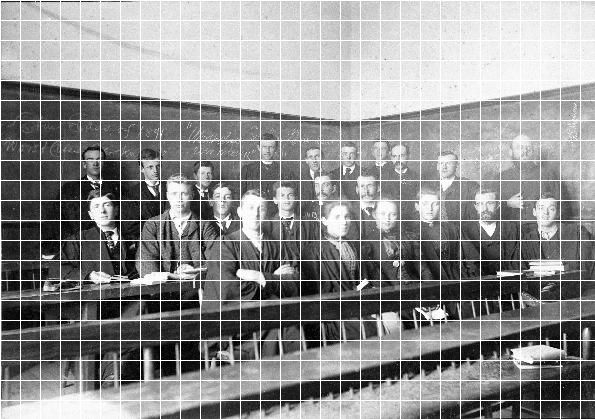

In [7]:
# create a working copy
foo = photo.copy()

# colour, spacing for our lattice
step = 20
colour = 255

# iterate over all pixels
for x in range(foo.width):
    for y in range(foo.height):
        # draw the grid
        if x % step == 0 or y % step == 0:
            foo.putpixel((x,y), colour)
foo

<div class="alert alert-success">
<h4>🤔 Take a minute to try&hellip;</h4>
<ul style="margin-top:1em;">
<li>resizing the grid</li>
<li>changing its colour</li>
</ul>
</div>

### The Checkerboard revisited

Let's try repeating the checkerboard pattern as well:
 - save a fresh copy of the image to `foo`
 - reuse the checkerboard code:
   - colour black squares black
   - leave pixels of the "white" squares unchanged

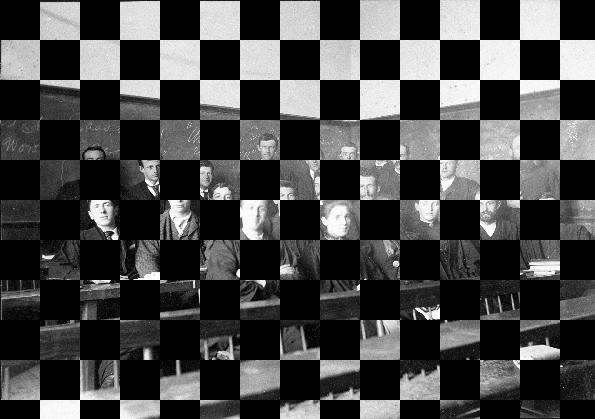

In [8]:
#HIDE
# start with a fresh copy of the image
foo = photo.copy()

# set the step parameters
step_x = 40
step_y = 40

# iterate over all pixels
for x in range(foo.width):
    for y in range(foo.height):
        # draw black squares only -- no `else` clause
        if (x // step_x) % 2 == (y // step_y) % 2:
            foo.putpixel((x,y), 0)
foo

<h3 id="peephole">Peephole</h3>

Let's mask everything except a circular region.

<ol>
<li>You choose values for&hellip;</li>
<ul style="margin-top:0em; margin-bottom:1em;">
<li>a point <code>(cent_x, cent_y)</code> somewhere on the image</li>
<li>a radius <code>rad</code> (in pixels)</li>
<li>a colour <code>col</code> for the mask</li>
</ul>
<li>Now, for every pixel <code>(x, y)</code>:</li>
<ul style="margin-top:0em; margin-bottom:1em;">
<li>if the distance from <code>(x, y)</code> to <code>(cent_x, cent_y)</code>is less than <code>rad</code>, leave it alone</li>
<li>otherwise, set the pixel value to <code>col</code></li>
</ul>
</ol>
<strong>Hint:</strong>
<ul>
<li>For calculating distance, refer to the circular gradient exercise</li>
</ul>

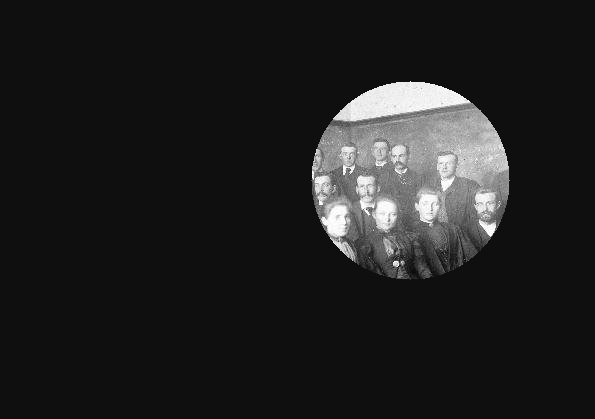

In [9]:
#HIDE
# need math module for square root
import math

# start with a fresh copy of the image
foo = photo.copy()

# set variables
cent_x = 410
cent_y = 180
rad = 99
col = 15

# iterate over all pixels
for x in range(foo.width):
    for y in range(foo.height):
        # get distance to centre
        dist = math.sqrt((x - cent_x)**2 + (y - cent_y)**2)
        # if outside radius, mask pixel
        if dist > rad:
            foo.putpixel((x, y), col)

# display result
foo

### Pixelate

In this exercise, we divide the image up into imaginary blocks, as in the checkerboard or lattice examples. The twist: we determine the value of the centre pixel for each block, then make all the rest of the pixels in that block match it.

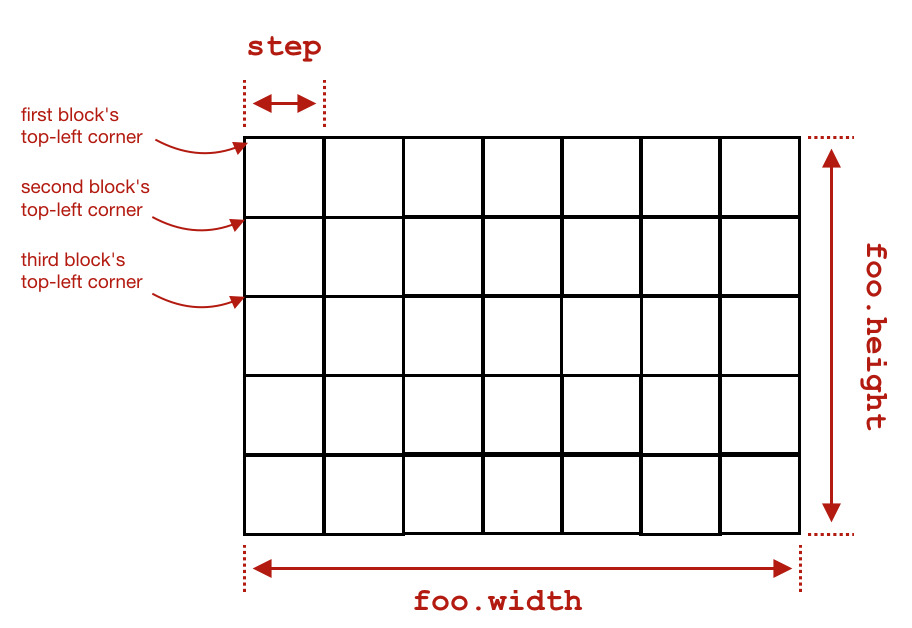

<h5>Divide the image into blocks</h5>
<p>Choose the size of blocks you want (e.g. 3×3). Create a variable <code>step</code> equal to the length of one side of the block (e.g. 3 pixels).</p>
<h5>Iterate over the blocks</h5>
<ul>
<li>Use nested <code>for</code> loops to move an imaginary top-left corner across the image, block by block.</li>
<li>We're not iterating over every single pixel, this time</li>
<li>Instead, we're moving by <code>step</code> each time. So you'll need to use that version of <code>range()</code> that specifies <code>start</code>, <code>stop</code>, and <code>step</code> values.</li>
</ul>
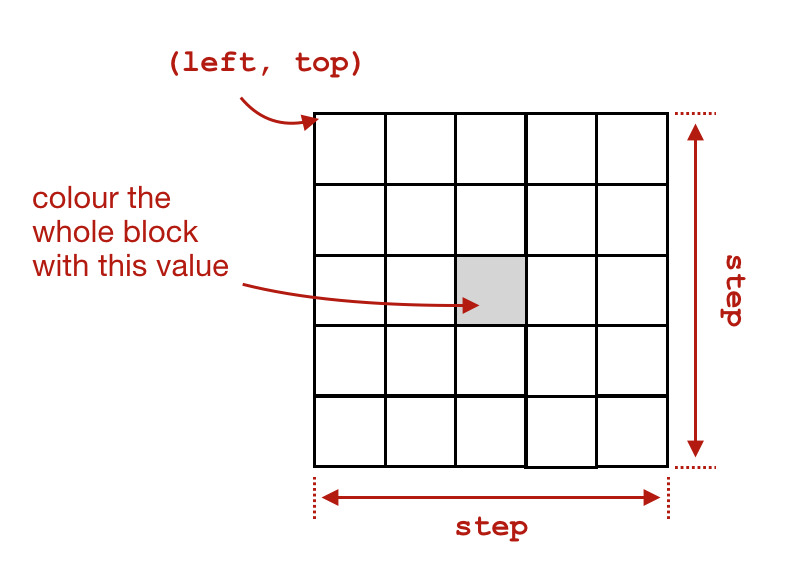
<h5>For each block, find the value of the center pixel.</h5>
<p>You can determine the <code>(x, y)</code> coordinates for this pixel based on the current <code>(left, top)</code> and the value of <code>step</code>.</p>
<h5>Now colour the whole block in</h5>
<p>This will require another set of nested <code>for</code> loops, iterating <code>(x, y)</code> over all values from <code>(left, top)</code> to <code>(left+step, top+step)</code>.
</p>

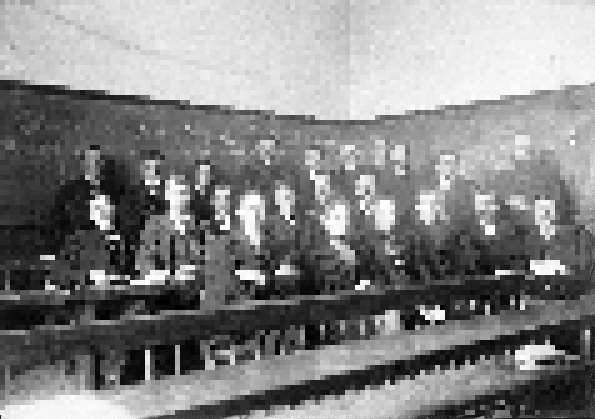

In [10]:
#HIDE
# start with a fresh copy of the image
foo = photo.copy()

# block size
step = 5

# move by skips across the image
for left in range(0, foo.width-step, step):
    for top in range(0, foo.height-step, step):
        # get value of central pixel
        grey_val = foo.getpixel((left + step // 2, top + step // 2))
        
        # now iterate over the whole block, colour it in
        for x in range(left, left + step):
            for y in range(top, top + step):
                foo.putpixel((x, y), grey_val)
foo

### Simple Filter

So far, we've been calculating pixel values based on position. We can make things more interesting if we use the values of neighbouring pixels as part of our calculation.

In the next example, we set the value of each pixel to the average of its neighbours.

<h5>preliminaries</h5>
<ul style="margin-top:1em; margin-bottom:1em">
<li>As usual, start by creating a fresh copy of the image</li>
<li>Decide what size you want the blocks. Set a variable <code>size</code> to half that.
<li>As before, use nested <code>for</code> loops to iterate over every pair of <code>(x, y)</code></li>
</ul>

<h5>for each pixel <code>(x, y)</code></h5>
<p>
Imagine a block extending <code>size</code> pixels in every direction, with the current pixel at the centre. We want to calculate the mean value for all pixels in that block. That means 👉🏻 iterating over all those pixels, 👉🏻 adding their values together, and then 👉🏻 dividing by the number of pixels in the block.
</p>
<p>
<ul style="margin-top:1em; margin-bottom:1em">
<li>Start with a variable <code>grey_val</code> set to zero</li>
<li>You'll need another set of nested <code>for</code> loops to iterate over the block of pixels</li>
<ul style="margin-top:1em; margin-bottom:0em">
<li><code>working_x</code> needs to iterate from <code>x - size</code> to <code>x + size</code></li>
<li><code>working_y</code> needs to iterate from <code>y - size</code> to <code>y + size</code></li>
<li><strong>Note:</strong> you'll have to make sure you don't go out of bounds near the edge of the image</li>
</ul>
<li>For each <code>(working_x, working_y)</code> add the value of that pixel to <code>grey_val</code>.</li>
<li>When you're done, <code>grey_val</code> will be equal to the sum of all the pixels in the block.</li>
<li>Now divide by the number of pixels in the block to get the mean value.</li>
</ul>
<h5>colouring in the pixel</h5>
<p>Now that you've found the mean value, set the pixel at <code>(x, y)</code>. <strong>Careful:</strong> if you're altering the image as you go, then pixels you've already changed will affect the calculations for their neighbours. You can avoid this by using 👉🏻  <code><strong>photo</strong>.getpixel()</code> to check pixel values in the <strong>unaltered original</strong> image, and 👉🏻 <code><strong>foo</strong>.putpixel()</code> to set values on your <strong>working copy</strong>.</p>
</div>

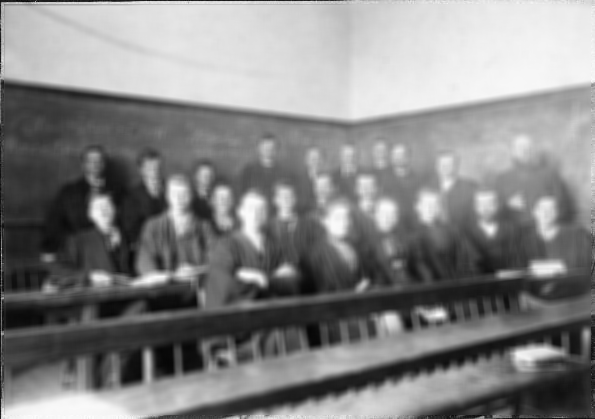

In [11]:
#HIDE
# start with a fresh copy of the image
foo = photo.copy()

# how far (in either direction) to calculate average
size = 4

# iterate over all pixels
for x in range(size, foo.width - size):
    for y in range(size, foo.height - size):
        grey_val = 0
        
        for working_x in range(x - size, x + size):
            for working_y in range(y - size, y + size):
                grey_val = grey_val + photo.getpixel((working_x, working_y))
        grey_val = grey_val//(4 * size ** 2)

        foo.putpixel((x, y), grey_val)
foo

### bonus: swiss cheese

<p>Unlike the peephole exercise, which starts with the photo and blacks everything out around the "hole", this works by starting with a blank image and then copying each circular "hole" pixel-by-pixel from the 1891 photo.</p>

<strong>Hint:</strong> It's more fun if you start off with <code>import random</code>. 
<ul><li>Then you can randomize the hole centres and radii.</li>
<li>Use <a href="https://docs.python.org/3.6/library/random.html?highlight=randint#functions-for-integers" target="_blank"><code>random.randint(low, high)</code></a> to generate a random number between <code>low</code> and <code>high</code>.</li>
</ul>
<strong>Hint:</strong> If you have a lot (e.g. > 50) of holes in your cheese, this can be slow.

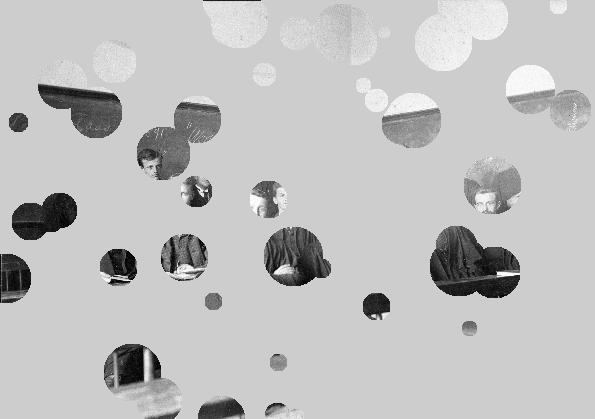

In [12]:
#HIDE
# random module makes things more interesting
import random

# create a blank image
foo = Image.new('L', (photo.width, photo.height), 205)

for i in range(50):
    # set variables
    cent_x = random.randint(0, foo.width)
    cent_y = random.randint(0, foo.height)
    rad = random.randint(6, 30)

    # iterate over all pixels
    for x in range(foo.width):
        for y in range(foo.height):
            # get distance to centre
            dist = math.sqrt((x - cent_x)**2 + (y - cent_y)**2)
            # if inside radius, copy pixel from photo
            if dist < rad:
                value = photo.getpixel((x, y))
                foo.putpixel((x, y), value)

# display result
foo